<a href="https://colab.research.google.com/github/mehtamohit013/comms_lidar_ML/blob/main/BS_Selection/federated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab - Once per runtime

In [1]:
!nvidia-smi

Sun Aug 29 12:03:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%%capture _
!unzip /gdrive/MyDrive/BTP/webots_data/final/data_split.zip
# !unzip /gdrive/MyDrive/BTP/Webots_data/val_data.zip
!pip install pytorch-lightning

In [1]:
!pip install  --upgrade pandas

# Imports

In [2]:
%load_ext tensorboard

In [47]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from enum import Enum

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
import os
import matplotlib.pyplot as plt
import random
import scipy.io as io
import math
import getpass
import time
from typing import Union

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

seed = 0

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Hyper-params

In [4]:
user = getpass.getuser()

if user == 'root':  #For google colab
    data_dir = '.'
    save_dir = './model_state_dict'
elif user == 'mohit':
    data_dir = os.environ['HOME'] + '/webots_code/data'
    save_dir = os.path.join(os.environ['HOME'],'webots_code/model_state_dict')
elif user == 'iiti':
    data_dir = os.environ['HOME'] + '/webots_code/data'
    save_dir = os.path.join(os.environ['HOME'],'webots_code/model_state_dict')
else:
    print(f'User {user} not present.\n Exiting.....')
    exit(0)

os.makedirs(save_dir,exist_ok=True)

train_gps = pd.read_pickle(os.path.join(data_dir,'train.pkl')).reset_index(drop=True)
val_gps = pd.read_pickle(os.path.join(data_dir,'val.pkl')).reset_index(drop=True)
test_gps = pd.read_pickle(os.path.join(data_dir,'test.pkl')).reset_index(drop=True)

len_train = len(train_gps)
len_val = len(val_gps)
len_test = len(test_gps)


lpath = os.path.join(data_dir,'lidar_compressed')
labpath = os.path.join(data_dir,'labels')


len_train = len(train_gps)
len_val = len(val_gps)
len_test = len(test_gps)

BS = np.array([
    [38.89502,-77.07303,5],
    [38.89442,-77.07294,5],
    [38.89452,-77.07358,5]
])
num_BS = int(BS.shape[0])

BATCH_SIZE = 64

if (user=='root'):
    n_worker = 2
else:
    n_worker = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Utilities

In [5]:
def top_k_acc(y_true:torch.Tensor,y_pred:torch.Tensor,k=1):
    
    y_pred_tpk = torch.topk(y_pred,k,dim=1)[1]
    
    ovr = 0
    pos = 0

    for i in range(0,len(y_pred_tpk)):
        if(y_true[i] in y_pred_tpk[i]):
            pos+=1
        ovr+=1
    
    acc = float(pos)/float(ovr)
    return acc

In [6]:
train_gps.at[0,'Lidar'][:-4]

'SUMO vehicle 23845.9'

# Creating Dataset and Dataloader

## Custom Dataset
Using 'GPS' currently.Translation can also be used instead of gps

In [7]:
class bs_dataset(Dataset):
    def __init__(self,gps_pd:pd.DataFrame,
                lpath:str=lpath,label_path:str=labpath):
    
        self.gps = gps_pd
        self.lpath = lpath
        self.label_path = label_path
        
    def __getitem__(self,index):
        filename = self.gps.at[index,'Lidar']
        sample = dict() 

        sample['lidar'] = dict(np.load(os.path.join(self.lpath,filename)))['lidar'] #[10,240,240]
        sample['lidar'] = sample['lidar'].astype('float32')
        sample['gps'] = np.array(self.gps.at[index,'GPS'])[1].astype('float32') # Central GPS coord
        sample['BS'] = self.gps.at[index,'BS'].reshape((3*num_BS,)).astype('float32') #[num_BS*3,]
        sample['label'] = io.loadmat(self.label_path+f'/{filename[:-3]}mat')['ss']
        
        #Return the index of maximum element 
        sample['label'] = np.argmax(sample['label'].astype('float32')) 
        
        return sample
    
    def __len__(self):
        return len(self.gps)

In [8]:
train_dataset = bs_dataset(train_gps)
val_dataset = bs_dataset(val_gps)
test_dataset = bs_dataset(test_gps)

## Dataloader

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True,
    shuffle = True
    )

In [10]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

In [11]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
)

# Models
Based on Imperial Model

## GPS Class

In [12]:
class gps_bs_sel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(12,16)
        self.linear2 = nn.Linear(16,32)
        self.linear3 = nn.Linear(32,64)
        self.linear4 = nn.Linear(64,32)
        self.linear5 = nn.Linear(32,16)
        self.linear6 = nn.Linear(16,8)
        self.linear7 = nn.Linear(8,3)
        
        self.relu = nn.ReLU()
    
    def forward(self,gps,BS):

        x = torch.cat([gps,BS],dim=1)
        
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.relu(out)
        out = self.linear6(out)
        out = self.relu(out)
        out = self.linear7(out)

        return out

## Lidar Class

### NU Huskies
Resnet based architecture exploiting Residual connection


In [13]:
class NU(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        self.drop_prob = drp
        self.drop = nn.Dropout(self.drop_prob)

        self.conv0 = nn.Sequential(nn.Conv2d(10,3,(3,3)),nn.ReLU())
        self.conv1 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())

        self.m_pool1 = nn.MaxPool2d((2,2))
        self.m_pool2 = nn.MaxPool2d((1,2))

        self.flatten = nn.Flatten()

        self.drop_prob_fc = drp_fc
        self.drop_fc = nn.Dropout(self.drop_prob_fc)
        self.fc = nn.Sequential(nn.Linear(5400,512),
                                nn.ReLU(),
                                self.drop_fc,
                                nn.Linear(512,256),
                                nn.ReLU(),
                                self.drop_fc,
                                nn.Linear(256,3)
                                )
        
    def forward(self,X):
        a = X = self.conv0(X)
        X = F.pad(X,(1,1,1,1))
        a = F.pad(a,(1,1,1,1))
        X = self.conv1(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv2(X)
        X = F.pad(X,(1,1,1,1))
        X = X+a
        X = self.m_pool1(X)


        b = X= self.drop(X)

        X = self.conv3(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv4(X)
        X = F.pad(X,(1,1,1,1))
        X = X+b
        X = self.m_pool1(X)

        c = X = self.drop(X)

        X = self.conv5(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv6(X)
        X = F.pad(X,(1,1,1,1))
        X = X + c
        X = self.m_pool2(X)
        
        d = X = self.drop(X)

        X = self.conv7(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv8(X)
        X = F.pad(X,(1,1,1,1))
        X = X + d

        out = self.flatten(X)
        out = self.fc(out)
        
        return out


### Imperial

Simple CNN based on imperial model

Adding dropout for reduction in overfitting

In [14]:
class imp_lidar(nn.Module):
    def __init__(self,drp:float=0.2,drp_fc:float=0.2):
        super().__init__()
        
        self.drop_CNN = nn.Dropout(drp)
        self.drop_fc = nn.Dropout(drp_fc)

        self.channels = 5
        self.fchannel = 3
        self.conv1 = nn.Conv2d(10,self.channels, 13, 1, 1)
        self.bn1 = nn.BatchNorm2d(self.channels)
        self.relu1 = nn.PReLU(num_parameters=self.channels)
        self.conv2 = nn.Conv2d(self.channels, self.channels, 13, 1, 1)
        self.bn2 = nn.BatchNorm2d(self.channels)
        self.relu2 = nn.PReLU(num_parameters=self.channels)
        self.conv3 = nn.Conv2d(self.channels, self.channels, 7, 2, 1)
        self.bn3 = nn.BatchNorm2d(self.channels)
        self.relu3 = nn.PReLU(num_parameters=self.channels)
        self.conv4 = nn.Conv2d(self.channels, self.channels, 7, 1, 1)
        self.bn4 = nn.BatchNorm2d(self.channels)
        self.relu4 = nn.PReLU(num_parameters=self.channels)
        self.conv5 = nn.Conv2d(self.channels, self.fchannel, 5, 2, 1)
        self.bn5 = nn.BatchNorm2d(self.fchannel)
        self.relu5 = nn.PReLU(num_parameters=self.fchannel)
        self.conv6 = nn.Conv2d(self.fchannel, 1, 5, (1, 2), 1)
        self.bn6 = nn.BatchNorm2d(1)
        self.relu6 = nn.PReLU(num_parameters=1)

        self.flatten = nn.Flatten()
        self.linear7 = nn.Linear(1225,256)
        self.relu7 = nn.ReLU()

        self.linear8 = nn.Linear(256,16)
        self.linear9 = nn.Linear(16,3)

    def forward(self,x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)

        x = self.drop_CNN(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
      
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn3(x)

        x = self.drop_CNN(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)

        x = self.conv6(x)
        x = self.relu6(x)
        x = self.bn6(x)

        x = self.drop_CNN(x)

        x = self.flatten(x)
        x = self.linear7(x)
        x = self.relu7(x)
        x = self.drop_fc(x)

        x = self.linear8(x)
        x= self.relu7(x)
        x = self.drop_fc(x)
        
        out = self.linear9(x)

        return out


### Model 1
Resnet based architecture but with higher kernel size, inspired from the results of imp model

Reason : As data is sparse higher kernel size may enable better computation

Convolution Output size : [(W−K+2P)/S]+1

*   W is the input volume 
*   K is the Kernel size 
*   P is the padding 
*   S is the stride 


In [15]:
class m1(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        self.drop_prob = drp
        self.drop = nn.Dropout(self.drop_prob)

        self.conv0 = nn.Sequential(nn.Conv2d(10,3,(13,13)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv1 = nn.Sequential(nn.Conv2d(3,3,(11,11)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv2 = nn.Sequential(nn.Conv2d(3,3,(11,11)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv3 = nn.Sequential(nn.Conv2d(3,3,(7,7)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv4 = nn.Sequential(nn.Conv2d(3,3,(7,7)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv5 = nn.Sequential(nn.Conv2d(3,3,(5,5)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv6 = nn.Sequential(nn.Conv2d(3,3,(5,5)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv7 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv8 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.BatchNorm2d(3),nn.PReLU(3))

        self.m_pool1 = nn.MaxPool2d((2,2))
        self.m_pool2 = nn.MaxPool2d((1,2))

        self.flatten = nn.Flatten()

        self.drop_prob_fc = drp_fc
        self.drop_fc = nn.Dropout(self.drop_prob_fc)
        self.fc = nn.Sequential(nn.Linear(4788,512),
                                nn.PReLU(1),
                                self.drop_fc,
                                nn.Linear(512,256),
                                nn.PReLU(1),
                                self.drop_fc,
                                nn.Linear(256,3)
                                )
        
    def forward(self,X):
        a = X = self.conv0(X)

        X = self.conv1(X)
        X = F.pad(X,(5,5,5,5))
        X = self.conv2(X)
        X = F.pad(X,(5,5,5,5))
        X = X+a
        X = self.m_pool1(X)


        b = X= self.drop(X)

        X = self.conv3(X)
        X = F.pad(X,(3,3,3,3))
        X = self.conv4(X)
        X = F.pad(X,(3,3,3,3))
        X = X+b
        X = self.m_pool1(X)

        c = X = self.drop(X)

        X = self.conv5(X)
        X = F.pad(X,(2,2,2,2))
        X = self.conv6(X)
        X = F.pad(X,(2,2,2,2))
        X = X + c
        X = self.m_pool2(X)
        
        d = X = self.drop(X)

        X = self.conv7(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv8(X)
        X = F.pad(X,(1,1,1,1))
        X = X + d

        out = self.flatten(X)
        out = self.fc(out)
        
        return out

In [16]:
# tmp = m1()

In [17]:
# a = torch.rand(1,10,240,240)
# tmp(a)

### Inception based model

In [18]:
class incp(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        
        self.drop_CNN = nn.Dropout(drp)
        self.drop_fc = nn.Dropout(drp_fc)
        self.mpool = nn.MaxPool2d((2,2))
        self.channels = 5
        self.fchannel = 3
        self.conv1 = self.create_conv(10,self.channels,13)
        self.conv2 = self.create_conv(self.channels,self.channels,13)
        self.conv3 = self.create_conv(self.channels,self.channels,7)
        self.conv4 = self.create_conv(self.channels,self.channels,7)

        # 1st Inception block
        self.in1 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in2 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in3 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.channels,self.fchannel,1)
        )
        self.in4 = self.create_conv(self.channels,self.fchannel,1)

        # Second inception block
        self.in5 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in6 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,3)
        )
        self.in7 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.fchannel*4,self.fchannel,1)
        )
        self.in8 = self.create_conv(self.fchannel*4,self.fchannel,1)

        self.conv5 = self.create_conv(self.fchannel*4,self.fchannel*4,7)
        self.conv6 = self.create_conv(self.fchannel*4,self.fchannel*4,7)

        self.conv7 = self.create_conv(self.fchannel*4,self.fchannel*4,3)
        self.conv8 = self.create_conv(self.fchannel*4,self.fchannel*4,3)
        
        self.flatten = nn.Flatten()

        self.linear = nn.Sequential(
            nn.Linear(2352,256),
            nn.PReLU(1),
            nn.BatchNorm1d(256),
            self.drop_fc,
            nn.Linear(256,64),
            nn.PReLU(1),
            nn.BatchNorm1d(64),
            self.drop_fc,
            nn.Linear(64,16),
            nn.PReLU(1),
            nn.BatchNorm1d(16),
            self.drop_fc,
            nn.Linear(16,3)
        )

    
    def forward(self,X):
        X  = self.conv1(X)
        X  = self.conv2(X)
        X = self.mpool(X)

        X = self.conv3(X)
        X = self.conv4(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        a = self.in1(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in2(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in3(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in4(X)

        X = torch.cat((a,b,c,d),1)

        X = self.drop_CNN(X)

        a = self.in5(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in6(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in7(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in8(X)

        X = torch.cat((a,b,c,d),1)
        X = self.drop_CNN(X)

        X = self.conv5(X)
        X = self.conv6(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        X = self.conv7(X)
        X = self.conv8(X)

        X = self.flatten(X)
        out = self.linear(X)

        return out
    
    def create_conv(self,in_layers:int,out_layers:int,kernel,stride:int=1,
                    padding:int=0) -> nn.Module :

        return nn.Sequential(
            nn.Conv2d(in_layers,out_layers,kernel,stride,padding),
            nn.PReLU(out_layers),
            nn.BatchNorm2d(out_layers)
        )

In [19]:
tmp = incp()
a = torch.rand(2,10,240,240)
tmp(a)
sum(p.numel() for p in tmp.parameters())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


653931

## Lidar + GPS Class

In [20]:
class bs_model(nn.Module):
    def __init__(self,drop_prob:float=0.0,
                 drop_prob_fc:float=0.0):
        super().__init__()
        self.drop_CNN = nn.Dropout(drop_prob)
        self.drop_fc = nn.Dropout(drop_prob_fc)
        self.mpool = nn.MaxPool2d((2,2))
        self.channels = 5
        self.fchannel = 3
        self.conv1 = self.create_conv(10,self.channels,13)
        self.conv2 = self.create_conv(self.channels,self.channels,13)
        self.conv3 = self.create_conv(self.channels,self.channels,7)
        self.conv4 = self.create_conv(self.channels,self.channels,7)

        # 1st Inception block
        self.in1 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in2 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in3 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.channels,self.fchannel,1)
        )
        self.in4 = self.create_conv(self.channels,self.fchannel,1)

        # Second inception block
        self.in5 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in6 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,3)
        )
        self.in7 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.fchannel*4,self.fchannel,1)
        )
        self.in8 = self.create_conv(self.fchannel*4,self.fchannel,1)

        self.conv5 = self.create_conv(self.fchannel*4,self.fchannel*4,7)
        self.conv6 = self.create_conv(self.fchannel*4,self.fchannel*4,7)

        self.conv7 = self.create_conv(self.fchannel*4,self.fchannel*4,3)
        self.conv8 = self.create_conv(self.fchannel*4,self.fchannel*4,3)
        
        self.flatten = nn.Flatten()

        self.lidar_linear = nn.Sequential(
                            nn.Linear(2352,256),
                            self.drop_fc,
                            nn.PReLU(1),
                            nn.Linear(256,128),
                            self.drop_fc,
                            nn.PReLU(1)
        )
        
        self.coord_linear = nn.Sequential(
                            nn.Linear(12,8),
                            self.drop_fc,
                            nn.PReLU(1),
                            nn.Linear(8,4),
                            self.drop_fc,
                            nn.PReLU(1)
        )

        self.cat_linear = nn.Sequential(
                            nn.Linear(132,64),
                            nn.PReLU(1),
                            self.drop_fc,
                            nn.Linear(64,16),
                            nn.PReLU(1),
                            self.drop_fc,
                            nn.Linear(16,3)
        )



    def forward(self, input):

        [X,gps,bs] = input

        X  = self.conv1(X)
        X  = self.conv2(X)
        X = self.mpool(X)

        X = self.conv3(X)
        X = self.conv4(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        a = self.in1(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in2(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in3(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in4(X)

        X = torch.cat((a,b,c,d),1)

        X = self.drop_CNN(X)

        a = self.in5(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in6(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in7(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in8(X)

        X = torch.cat((a,b,c,d),1)
        X = self.drop_CNN(X)

        X = self.conv5(X)
        X = self.conv6(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        X = self.conv7(X)
        X = self.conv8(X)

        X = self.flatten(X)
        X = self.lidar_linear(X)

        coord = torch.cat((gps,bs),dim=1)
        coord = self.coord_linear(coord)
        
        out = torch.cat((X,coord),dim=1)
        out = self.cat_linear(out)
        return out

    def create_conv(self,in_layers:int,out_layers:int,kernel,stride:int=1,
                    padding:int=0) -> nn.Module :

        return nn.Sequential(
            nn.Conv2d(in_layers,out_layers,kernel,stride,padding),
            nn.PReLU(out_layers),
            nn.BatchNorm2d(out_layers)
        )

In [21]:
# # For testing model shape and size
# model = bs_model()
# lidar = torch.Tensor(2,10,240,240)
# gps = torch.Tensor(2,3)
# BS = torch.Tensor(2,9)
# print(sum(p.numel() for p in model.parameters()))
# model([lidar,gps,BS])

# Training
Using pytorch lightning

## GPS

### Lightning class

In [ ]:
class gps_trainer(pl.LightningModule):
    def __init__(self,learning_rate = 1e-3):
        super().__init__()
        self.model = gps_bs_sel()
        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
    
    def forward(self,gps,BS):
        out = self.model(gps,BS)
        return out
    
    def training_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self(gps,BS)
        
        loss = self.celoss(yhat,label)
        
        self.log('my_loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        print(f'Test accuracy is {top1}')

### Class object and trainer

In [ ]:
gps_model = gps_trainer()

In [ ]:
gps_pl_trainer = pl.Trainer(
                    gpus=1,
                    max_epochs = 10,
                    auto_lr_find = False
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
gps_pl_trainer.fit(gps_model,train_loader,val_loader)
gps_pl_trainer.test(gps_model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: ignored

## Lidar

### Lightning Class

In [ ]:
class lidar_trainer(pl.LightningModule):
    def __init__(self,use_model:str,
                 drop_prob:float = 0.3,
                 drop_prob_fc:float = 0.2,
                 learning_rate:float = 1e-3,
                 weight_decay:float = 0.0):
        
        '''
        use_model = 'NU','imp'
        '''

        self.drp = drop_prob
        self.drp_fc = drop_prob_fc

        super().__init__()
        if use_model == 'NU':
            self.model = NU(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'imp':
            self.model = imp_lidar(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'm1':
            self.model = m1(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'incp':
            self.model = incp(drp=drop_prob,drp_fc = drop_prob_fc)

        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
        self.wd = weight_decay

        self.train_acc = 0
        self.val_acc = 0
        self.test_acc = 0

        self.example_input_array = torch.rand(1,10,240,240) # For logging graph
    
    def forward(self,lidar):
        out = self.model(lidar)
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self(lidar)
        
        loss = self.celoss(yhat,label)
        
        self.log('Train Loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr,
                               weight_decay=self.wd)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        # Calculating Avg loss
        avg_loss = torch.stack([x['loss'] for x in train_out]).mean()
        
        self.logger.experiment.add_scalar('Loss-Train per epoch',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('Train Accuracy',top1,self.current_epoch)

        self.train_acc = top1
        
        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.val_acc = top1

        self.logger.experiment.add_scalar('Validation Accuracy',top1,self.current_epoch)

        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.test_acc = top1

        self.logger.experiment.add_hparams(
            {
                'LR' : self.lr,
                'weight_decay' : self.wd,
                'drop_prob' : self.drp,
                'drop_fc' : self.drp_fc,
                'overall params' : sum(p.numel() for p in self.model.parameters())
            },
            {
                'hparam/test_acc' : self.test_acc,
                'hparam/train_acc' : self.train_acc,
                'hparam/val_acc' : self.val_acc
            }
        )
        print(f'Test accuracy is {top1}')

### Class object and trainer

In [ ]:
lidar_model = lidar_trainer(use_model='incp',drop_prob=0.0,drop_prob_fc=0.0,weight_decay=1e-4)

In [ ]:
logger = TensorBoardLogger("tb_logs", name="inception",log_graph=True,default_hp_metric=False)
lidar_pl_trainer = pl.Trainer(
                     gpus=1,
                     max_epochs = 5,
                     precision = 16,
                     logger = logger,
                     amp_backend = 'native',
                     auto_lr_find = True
                     )

In [ ]:
# lidar_pl_trainer.tune(lidar_model,train_loader,val_loader)
lidar_pl_trainer.fit(lidar_model,train_loader,val_loader)
lidar_pl_trainer.test(lidar_model,test_loader)

## Lidar + GPS

### Lightning Class

In [ ]:
class BS_trainer(pl.LightningModule):
    def __init__(self,drop_prob:float = 0.3,
                 drop_prob_fc:float = 0.2,
                 learning_rate:float = 1e-3,
                 weight_decay:float = 0.0):
        
        super().__init__()

        self.drp = drop_prob
        self.drp_fc = drop_prob_fc
        self.lr = learning_rate
        self.wd = weight_decay

        self.model = bs_model(self.drp,self.drp_fc)
        self.celoss = nn.CrossEntropyLoss()

        self.train_acc = 0
        self.val_acc = 0
        self.test_acc = 0

        self.example_input_array = [torch.rand(1,10,240,240),torch.rand(1,3),torch.rand(1,9)] # For logging graph
    
    def forward(self,lidar,gps,BS):
        out = self.model([lidar,gps,BS])
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self(lidar,gps,BS)
        
        loss = self.celoss(yhat,label)
        
        self.log('Train Loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr,weight_decay=self.wd)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        # Calculating Avg loss
        avg_loss = torch.stack([x['loss'] for x in train_out]).mean()

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.train_acc = top1

        self.logger.experiment.add_scalar('Loss-Train per epoch',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('Train Accuracy',top1,self.current_epoch)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar,gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.val_acc = top1

        self.logger.experiment.add_scalar('Validation Accuracy',top1,self.current_epoch)
        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar,gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.test_acc = top1

        self.logger.experiment.add_hparams(
            {
                'LR' : self.lr,
                'weight_decay' : self.wd,
                'drop_prob' : self.drp,
                'drop_fc' : self.drp_fc,
                'overall params' : sum(p.numel() for p in self.model.parameters())
            },
            {
                'hparam/test_acc' : self.test_acc,
                'hparam/train_acc' : self.train_acc,
                'hparam/val_acc' : self.val_acc
            }
        )
        print(f'Test accuracy is {top1}')

### Class object and trainer 

In [ ]:
model = BS_trainer(drop_prob=0.0,drop_prob_fc=0.0,weight_decay=0)

In [ ]:
logger = TensorBoardLogger("tb_logs", name="lidar_gps",log_graph=True,default_hp_metric=False)
lidar_gps_pl_trainer =  pl.Trainer(
                     gpus=1,
                     max_epochs = 5,
                     precision = 16,
                     logger = logger,
                     amp_backend = 'native',
                     auto_lr_find = True
                     )

In [ ]:
lidar_gps_pl_trainer.fit(model,train_loader,val_loader)
lidar_gps_pl_trainer.test(model,test_loader)

In [ ]:
!zip -r tb_logs.zip tb_logs

In [ ]:
%tensorboard --logdir tb_logs/lidar_gps

# Accuracy based on distance

In [ ]:
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


In [ ]:
y_pred = list()
pos = 0
ovr = 0 
for i in range(0,len_train):
    data = train_dataset[i]
    dist1 = dist_gps(data['gps'],data['BS'][:3])
    dist2 = dist_gps(data['gps'],data['BS'][3:6])
    dist3 = dist_gps(data['gps'],data['BS'][6:9])

    # print(dist1,dist2,dist3)
    
    index = np.argmax(np.array([dist1,dist2,dist3]))

    # print(index,data['label'])

    if index == data['label']:
        pos+=1
    ovr+=1
    # if((i+1)%10==0):
    #     break
print(f'Accuracy based on shortest distance on train is {pos/ovr}')

In [ ]:
y_pred = list()
pos = 0
ovr = 0 
for i in range(0,len_val):
    data = val_dataset[i]
    dist1 = dist_gps(data['gps'],data['BS'][:3])
    dist2 = dist_gps(data['gps'],data['BS'][3:6])
    dist3 = dist_gps(data['gps'],data['BS'][6:9])

    # print(dist1,dist2,dist3)
    
    index = np.argmax(np.array([dist1,dist2,dist3]))

    # print(index,data['label'])

    if index == data['label']:
        pos+=1
    ovr+=1
    # if((i+1)%10==0):
    #     break
print(f'Accuracy based on shortest distance on val is {pos/ovr}')

# Federated Learning (FedAvg)

Without retraining on baseline data on global server [link](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-3-ae2103c40c22)

## Hyper-params (For federated)

In [22]:
epoch_round = 2 # Number of epochs per dataset
cm_rounds = 5 #Overall communication round

# Available option : 'mean','wmean'
agg = 'mean' 
# Possible model_type: 'lg' : lidar + GPS,'l' : lidar,'g' : Gps 
model_type = 'l'

## Parameters

 Calculating number of cars

In [23]:
def cars_dist(data_pd:pd.DataFrame) -> list:
    car_list = list()
    car_sample = dict()
    for i in range(0,len_train):
        if not(data_pd.at[i,'Name'] in car_list):
            car_list.append(data_pd.at[i,'Name'])
            car_sample[int(data_pd.at[i,'Name'][-2:])] = list()
        car_sample[int(data_pd.at[i,'Name'][-2:])].append(i)

    return car_sample, car_list
    

In [24]:
train_car_sample,train_car_list = cars_dist(train_gps)

Plotting number of samples per car

<BarContainer object of 57 artists>

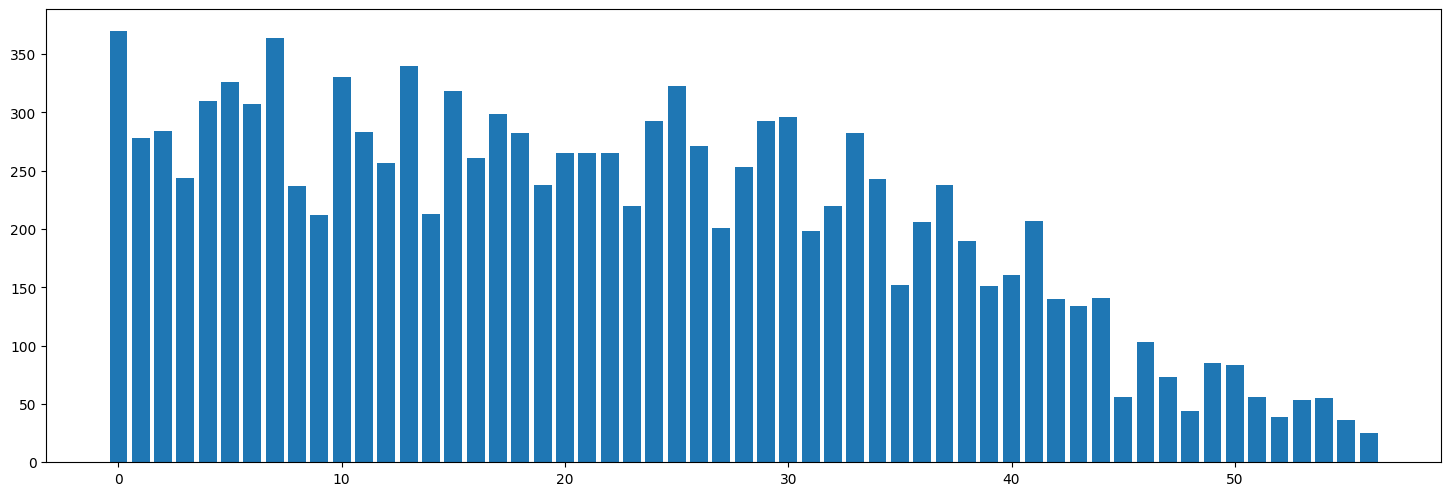

In [25]:
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 
len_car = [len(train_car_sample[i]) for i in range(0,len(train_car_list))]
plt.bar(range(0,len(train_car_list)),len_car)

## Creating Dataset and Dataloaders

### Dataset

In [26]:
cl_dataset = list()

for i in train_car_list:
    tmp = bs_dataset(train_gps[train_gps['Name']==i].reset_index(drop=True))
    cl_dataset.append(tmp)

### Dataloader

In [27]:
cl_loader = list()

for i in range(0,len(cl_dataset)):
    tmp = DataLoader(
        cl_dataset[i],
        batch_size=BATCH_SIZE,
        pin_memory=True,
        num_workers = n_worker,
        drop_last = True,
        shuffle = True
        )
    cl_loader.append(tmp)

## Model

### Client update

In [48]:
class client():
    
    '''
    Currently using standard trainer to train the model 
    '''
    def __init__(self,model:nn.Module,
                loader:DataLoader,
                epoch:int = epoch_round,
                model_type:str=model_type,
                wd=1e-4,lr=1e-3):
    
        self.model = model.to(device)
        self.loader = loader
        self.epoch = epoch
        self.model_type = model_type

        self.lr = lr
        self.wd = wd
        self.celoss = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(model.parameters(),self.lr,weight_decay=self.wd)
        self.start = time.time()

    def train(self):

        self.model.train()
        self.model.zero_grad()

        for i in range(0,self.epoch):

            # print('-'*10+f' Starting Epoch {i+1} '+'-'*10)
            
            running_loss = 0.0
            running_acc = 0.000
            
            for count,batch in enumerate(self.loader):

                self.opt.zero_grad()

                lidar = batch['lidar'].float().to(device)
                gps = batch['gps'].float().to(device)
                BS = batch['BS'].float().to(device)
                label = batch['label'].long().to(device)

                if self.model_type == 'lg':
                    yhat = self.model([lidar,gps,BS])
                elif self.model_type == 'l':
                    yhat = self.model(lidar)
                else:
                    yhat = self.model(gps,BS)
                
                loss = self.celoss(yhat,label)
                running_loss +=loss.item()
                
                loss.backward()
                self.opt.step()

                top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
                running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)

                # if count%1000 == 0 :
                #     print(f'Cross Entropy loss after {count} iterations is {running_loss/((count+1)*BATCH_SIZE)}. '\
                #           f'Time Elapsed {time.time()-self.start}')
                #     print(f'Accuracy on train after {count} iteration is {running_acc}')
            
            # print(f'Overall iteration completed {count}') #304
            # print('-'*10+f' Epoch {i+1} ends '+'-'*10)
            # print(f'Cross Entropy loss after {i+1} epochs is {running_loss/((count+1)*BATCH_SIZE)}'\
            #       f'Time Elapsed {time.time()-self.start}')
            # print(f'Accuracy on train after {i+1} epochs is {running_acc}')

### Global Server

In [52]:
class fed_server():
    def __init__(self,cars:int,cl_dataset,cl_loader,agg:str=agg,
                model_type:str=model_type,ovr_sample:int=len_train,
                val_loader:DataLoader=val_loader,
                train_loader:DataLoader=train_loader,
                wd:float = 1e-4):
        
        self.cars = cars
        self.dataset = cl_dataset
        self.loader = cl_loader
        self.agg = agg
        self.model_type = model_type
        self.ovr_sample = ovr_sample
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.writer = SummaryWriter(log_dir ='./tb_logs/federated',
                                    comment=self.model_type)

        self.wd = wd
        self.celoss = nn.CrossEntropyLoss()

        self.create_model() #Global Model
    
    def create_model(self):
        if self.model_type == 'lg':
            self.model = bs_model().to(device)
            self.sample_input = [torch.rand((2,10,240,240)).to(device),torch.rand((2,9)).to(device),torch.rand((2,9)).to(device)]
        elif self.model_type == 'l':
            self.model = incp(0,0).to(device)
            self.sample_input = torch.rand((2,10,240,240)).to(device)
        else:
            self.model = gps_bs_sel().to(device)
            self.sample_input = [torch.rand((2,3)).to(device),torch.rand((2,9)).to(device)]

        self.writer.add_graph(self.model,self.sample_input)
    
    def per_round(self,epoch):

        #Synchronizing client model with global model at start of each round
        cl_model = [self.model for i in range(0,self.cars)]
        for cmodel in cl_model:
            cmodel.load_state_dict(self.model.state_dict())


        # Training Client Model
        for i in tqdm_notebook(range(0,self.cars),desc='Cars'):
            # print('*'*3+f' Starting Client {i} ' +'*'*3)
            
            if not(len(self.loader[i])) :
                # print(f'Not enough samples for client {i}')
                cl_model[i].load_state_dict(self.model.state_dict())
                continue

            tmp = client(cl_model[i],self.loader[i],epoch,self.model_type,wd=self.wd)
            tmp.train()

        # Global aggregration
        global_dict = self.model.state_dict()

        for k in global_dict.keys():
            if self.agg == 'mean':
                
                global_dict[k] = torch.stack([cl_model[i].state_dict()[k].float() 
                                            for i in range(len(cl_model))], 0).mean(0)
            
            else:
                global_dict[k] = torch.sum(
                                        torch.stack([cl_model[i].state_dict()[k].float()*(float(len(cl_dataset[i]))/float(self.ovr_sample)) 
                                        for i in range(len(cl_model))], 0),
                                        0)
        
        self.model.load_state_dict(global_dict)
        print('Global Aggregration Successfull')
    
    def train(self,cm_rounds:int=cm_rounds,epoch_round:int=epoch_round):

        for i in tqdm_notebook(range(0,cm_rounds),desc='Rounds'):
            
            # print('-'*10+f' Staring round {i+1} '+ '-'*10)
            self.per_round(epoch_round)

            print('#'*3 + 'Train Accuracy '+ '#'*3)
            self.train_acc(i)
            
            print('#'*3 + 'Validation Accuracy '+ '#'*3)
            self.val(i)

    def train_acc(self,epoch:int):
        self.model.eval()
        running_loss = 0.0
        running_acc = 0.000
        running_loss = 0.0

        for count,batch in tqdm_notebook(enumerate(self.train_loader),desc='Train Metrics'):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if self.model_type == 'lg':
                yhat = self.model([lidar,gps,BS])
            elif self.model_type == 'l':
                yhat = self.model(lidar)
            else:
                yhat = self.model(gps,BS)

            loss = self.celoss(yhat,label)
            running_loss += loss.item()
            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        running_loss = running_loss/((count+1)*BATCH_SIZE)
        self.writer.add_scalar('Train Acc',running_acc,epoch)
        self.writer.add_scalar('Avg Train Loss per round',running_loss,epoch)
        print(f'Accuracy on train is {running_acc}')
    
    def val(self,epoch:int):

        self.model.eval()
        running_loss = 0.0
        running_acc = 0.000

        for count,batch in tqdm_notebook(enumerate(self.val_loader),desc='Val Metrics'):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if self.model_type == 'lg':
                yhat = self.model([lidar,gps,BS])
            elif self.model_type == 'l':
                yhat = self.model(lidar)
            else:
                yhat = self.model(gps,BS)

            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        self.writer.add_scalar('Val Acc',running_acc,epoch)
        print(f'Accuracy on val is {running_acc}')

## Training - Federated Learning

In [53]:
federated = fed_server(len(train_car_list),cl_dataset,cl_loader,agg,model_type,len_train,val_loader,train_loader)

In [54]:
federated.train(cm_rounds,epoch_round)

Rounds:   0%|          | 0/5 [00:00<?, ?it/s]

Cars:   0%|          | 0/57 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [32]:
torch.save(federated.model.state_dict(),'./model_dict.zip')

In [ ]:
%tensorboard --logdir ./tb_logs/federated/